In [2]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokeniser"

In [3]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

In [4]:
df = isot_full_df[isot_full_df['fulltext'].notna()]

In [5]:
df.shape

(38270, 8)

In [6]:
df['fulltext'].isnull().sum()

0

In [7]:
#df=df.iloc[0:2000]

In [8]:
x=df[['fulltext']]
y=df[['class']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y, random_state=0)

### BERT Embedding Layer

In [10]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

2022-06-22 22:38:24.309616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-22 22:38:24.309816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-22 22:38:24.309936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [11]:
MAX_SEQ_LEN=256
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

- input token ids is tokenizer converts tokens using vocab file.
- input masks are either 0 or 1. 1 for useful tokens, 0 for padding.
- segment ids are either 0 or 1. For 2 text training: 0 for the first one, 1 for the second one.

In [12]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [13]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Tokenisation

In [14]:
#Create the tokenizer with the BERT layer and import it tokenizer using the original vocab file.
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [15]:
### Helper function to 

In [16]:
def create_single_input(sentence,MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

In [17]:
train_sentences=X_train.fulltext.values
train_y = y_train.values
train_inputs=create_input_array(train_sentences)

test_sentences=X_test.fulltext.values
test_y = y_test.values
test_inputs=create_input_array(test_sentences)

100%|██████████| 7654/7654 [00:39<00:00, 195.18it/s]


In [18]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");


### CNN

In [19]:
# Model Checkpoint and EarlyStopping
filepath_cnn = "Updated//model_ISOT_CNN_BERT.h5" # Location to get the model
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_cnn = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_cnn = [checkpoint_cnn,es_cnn]

In [22]:
x= tf.keras.layers.Conv1D(32,kernel_size=3,padding='same', activation='relu')(sequence_output)
#x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(6, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

cnn_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [23]:
cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',       

In [24]:
history_cnn_bert=cnn_model.fit(train_inputs,train_y,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_cnn) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9775 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ac7abcdbf28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss improved from inf to 0.05566, saving model to Updated/model_ISOT_CNN_BERT.h5
192/192 [==============================] - 3514s 18s/step - loss: 0.0557 - accuracy: 0.9775 - val_loss: 0.0123 - val_accuracy: 0.9963
Epoch 2/2
192/192 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9991 
Epoch 2: loss improved from 0.05566 to 0.00365, saving model to Updated/model_ISOT_CNN_BERT.h5
192/192 [==============================] - 4189s 22s/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0077 - val_accuracy: 0.9976


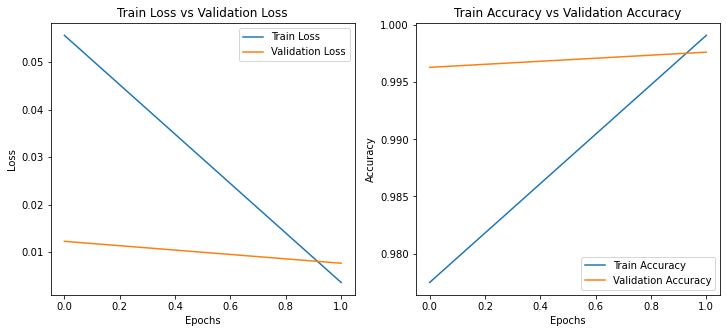

In [25]:
plot_loss_and_acc(history_cnn_bert)

## LSTM

In [71]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "Updated//model_ISOT_LSTM_BERT.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

In [72]:
x= tf.keras.layers.LSTM(16)(sequence_output)
x=tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(6, activation="relu")(x)
x=tf.keras.layers.Dropout(0.6)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

lstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [73]:
clear_session()

In [74]:
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',         

In [75]:
history_lstm_bert=lstm_model.fit(train_inputs,train_y,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_lstm) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.8426 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b73b3f230d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss improved from inf to 0.45047, saving model to Updated/model_ISOT_LSTM_BERT.h5
192/192 [==============================] - 3322s 17s/step - loss: 0.4505 - accuracy: 0.8426 - val_loss: 0.3287 - val_accuracy: 0.9961
Epoch 2/2
192/192 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8509 
Epoch 2: loss improved from 0.45047 to 0.42661, saving model to Updated/model_ISOT_LSTM_BERT.h5
192/192 [==============================] - 3335s 17s/step - loss: 0.4266 - accuracy: 0.8509 - val_loss: 0.3240 - val_accuracy: 0.9907


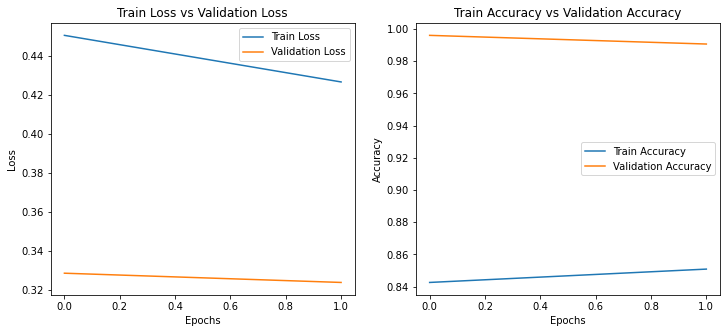

In [76]:
plot_loss_and_acc(history_lstm_bert)

### Bi-LSTM

In [60]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "Updated//model_ISOT_BILSTM_BERT.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

In [61]:
x= tf.keras.layers.Bidirectional(LSTM(16))(sequence_output)
x = tf.keras.layers.Dense(6, activation="relu")(x)
x=tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
x=tf.keras.layers.Dropout(0.5)(x)
bilstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

bilstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [62]:
clear_session()

In [63]:
bilstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',       

In [64]:
history_bilstm_bert=bilstm_model.fit(train_inputs,train_y,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.9517 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b73c8574400> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss improved from inf to 0.44375, saving model to Updated/model_ISOT_BILSTM_BERT.h5
192/192 [==============================] - 3368s 17s/step - loss: 0.4437 - accuracy: 0.9517 - val_loss: 0.3878 - val_accuracy: 0.9931
Epoch 2/2
192/192 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.9669 
Epoch 2: loss improved from 0.44375 to 0.42571, saving model to Updated/model_ISOT_BILSTM_BERT.h5
192/192 [==============================] - 3355s 17s/step - loss: 0.4257 - accuracy: 0.9669 - val_loss: 0.3841 - val_accuracy: 0.9967


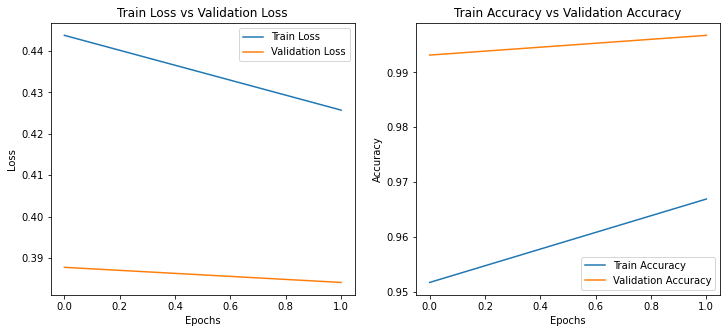

In [65]:
plot_loss_and_acc(history_bilstm_bert)